In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython import display

import warnings
warnings.filterwarnings('ignore')

# Aynı değerleri elde edebilmek için seed değerini sabitliyoruz.
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Veri linki / data link -> https://www.kaggle.com/datasets/muratkurtkaya/turkish-speech-command-dataset
DATASET_PATH = "C:\\Users\\Dell\\Desktop\\audio data"
data_dir = pathlib.Path(DATASET_PATH)
batch_size=32
sequence_length=16000 # ses verilerin uzunluğu 1 saniye ve klipler 16 kHz olduğu için 16000 yazdık.

train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=batch_size,
    seed=0,
    output_sequence_length=sequence_length) 
    
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 1870 files belonging to 1 classes.

label names: ['asagi']


In [3]:
# Ses kiplerinin sahip olduğu boyutlarına bakıyoruz. (batch, samples, channels)
# The audio clips have a shape of (batch, samples, channels).
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [4]:
#Bu veri seti tek bir kanal içerdiği için (mono olduğu için) tf.squeeze fonksiyonu ile kullanmadığımız axis'i atıyoruz.
#This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)

In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
audios=[]
for audio, audio_labels in train_ds:
    for i in audio:
      audios.append(i)
train_ds=np.array(audios)

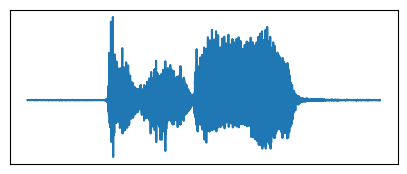

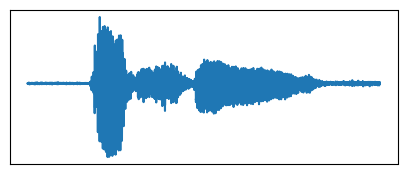

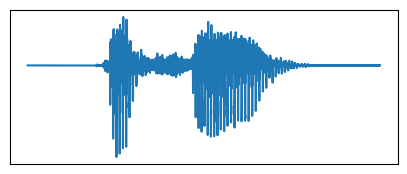

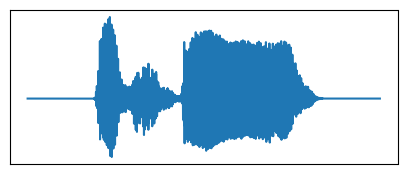

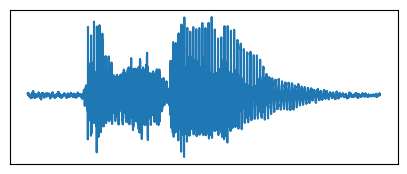

In [7]:
# Bir kaç veriye göz atalım.
# Let's look at some data
for i in range(5):
    plt.figure(figsize=(5,2))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.plot(train_ds[i])
    plt.show()
    display.display(display.Audio(train_ds[i], rate=sequence_length))

In [8]:
# Üretici ve Ayırıcı modellerimizi tanımlıyoruz.
# We define the Generator and Disciriminator 

from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

def create_generator():
    input_noise = Input(shape=(100,))
    
    x=Dense(units = 256, input_dim = 100)(input_noise)
    x=LeakyReLU()(x)
    
    x=Dense(units = 1024)(x)
    x=LeakyReLU()(x)
    
    x=Dense(units = 4096)(x)
    x=LeakyReLU()(x)

    x=Dense(units = 10240)(x)
    x=LeakyReLU()(x)
    
    x=Dense(units = sequence_length)(x)
    
    return Model(inputs=input_noise, outputs=x)

def create_discriminator():
    
    input_sound = Input(shape=(sequence_length,))
    
    x=Dense(units = 10240, input_dim = sequence_length)(input_sound)
    x=LeakyReLU()(x)
        
    x=Dense(units = 4096)(x) 
    x=LeakyReLU()(x)
        
    x=Dense(units = 1024)(x) 
    x=LeakyReLU()(x)

    x=Dense(units = 256)(x) 
    x=LeakyReLU()(x)
    
    x=Dense(units = 1, activation = "sigmoid")(x)
    
    return Model(inputs=input_sound, outputs=x)

generator = create_generator()
discriminator = create_discriminator()

In [9]:
# Oluşturduğumuz modelleri test için bir gürültü gönderiyoruz ve çıkış boyutlarının verimizle aynı boyuta sahip olup olmadığını 
# kontrol ediyoruz.

# We send a noise to test the model we created and, check if the output dimensions are same size as our data 

def get_noise(batch_size, nz=100):
    return tf.random.normal([batch_size, nz])

noise = get_noise(batch_size)

print("init", noise.shape)
fake_sounds = generator(noise)
print("Fake sounds", fake_sounds.shape)  # Boyutu olmalı / Should be (_, 16000)
preds = discriminator(fake_sounds)
print("Predictions", preds.shape) # Boyutu olmalı / Should be (_, 1)

init (32, 100)
Fake sounds (32, 16000)
Predictions (32, 1)


In [10]:
generator.summary()
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10240)          │    41,953,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16000)          │   163,856,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,296,704 (802.22 MB)

 Trainable params: 210,296,704 (802.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10240)          │   163,850,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │    41,947,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,255,361 (802.06 MB)

 Trainable params: 210,255,361 (802.06 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Hata fonksiyonlarını tanumlıyoruz.
# We define loss functions

from tensorflow.keras.losses import binary_crossentropy

def discriminator_loss(preds_real, preds_fake):
    loss_real = binary_crossentropy(tf.ones_like(preds_real), preds_real, from_logits=True) 
    loss_fake = binary_crossentropy(tf.zeros_like(preds_fake), preds_fake, from_logits=True)
    return loss_real + loss_fake


def generator_loss(preds_fake):
    return binary_crossentropy(tf.ones_like(preds_fake), preds_fake, from_logits=True)

In [12]:
# Optimizasyon fonksiyonlarını tanumlıyoruz.
# We define optimization functions
from tensorflow.keras.optimizers import Adam

optimizer_d = Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = Adam(learning_rate=1e-4, beta_1=0.5)

In [13]:
# Tek bir grup için eğitim adımını tanımlıyoruz. Fonksiyonu "derlemek" ve eğitimi biraz hızlandırmak için tf.function dekoratörünü kullanıyoruz.
# We define our train step for a single batch. We use the decorator tf.function to "compile" the function and speed up a bit the training.
@tf.function
def train_step(sounds):
    noise = get_noise(sounds.shape[0])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_sounds = generator(noise, training=True)

        real_output = discriminator(sounds, training=True)
        fake_output = discriminator(generated_sounds, training=True)

        gen_loss = generator_loss(preds_fake=fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_g.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss, gen_loss

In [14]:
data_generator = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(1000).batch(batch_size, drop_remainder=True)

In [15]:
# Modelimizi eğitebiliriz.
# We can train our model

from tensorflow.keras.metrics import Mean

epochs = 30

fixed_noise = get_noise(5)

print("Base noise:")
fake_sounds = generator(fixed_noise, training=False).numpy()
display.display(display.Audio(fake_sounds[0], rate=sequence_length))

for epoch in range(epochs):
    print("====== Epoch {:2d} ======".format(epoch))

    epoch_loss_d = Mean()
    epoch_loss_g = Mean()

    epoch_len = tf.data.experimental.cardinality(data_generator)
    for i, real_sounds in enumerate(data_generator):
        loss_d, loss_g = train_step(real_sounds)
        epoch_loss_d(loss_d)
        epoch_loss_g(loss_g)

        if i % 10 == 0 and i > 0:
            print(i, end=" ... ")

    print("\nDiscriminator: {}, Generator: {}".format(epoch_loss_d.result(), epoch_loss_g.result()))
    fake_sounds = generator(fixed_noise, training=False).numpy()
    display.display(display.Audio(fake_sounds[0], rate=sequence_length))

Base noise:


====== Epoch  0 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 2.311190366744995, Generator: 2.7552170753479004


====== Epoch  1 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.9966590404510498, Generator: 1.2256673574447632


====== Epoch  2 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.5960456728935242, Generator: 2.4165844917297363


====== Epoch  3 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.25697091221809387, Generator: 5.814026832580566


====== Epoch  4 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.1616344302892685, Generator: 8.689077377319336


====== Epoch  5 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.10414796322584152, Generator: 9.70988655090332


====== Epoch  6 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.10093291848897934, Generator: 12.26419448852539


====== Epoch  7 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.08766133338212967, Generator: 14.533223152160645


====== Epoch  8 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.7243582606315613, Generator: 8.505664825439453


====== Epoch  9 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.8057777285575867, Generator: 2.5446250438690186


====== Epoch 10 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.5524442195892334, Generator: 2.7651805877685547


====== Epoch 11 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.4970795810222626, Generator: 3.7997512817382812


====== Epoch 12 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.3867816925048828, Generator: 4.354886054992676


====== Epoch 13 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.30576857924461365, Generator: 5.589901447296143


====== Epoch 14 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.25257545709609985, Generator: 6.921690940856934


====== Epoch 15 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.2484372854232788, Generator: 6.4830732345581055


====== Epoch 16 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.2861913740634918, Generator: 7.58891487121582


====== Epoch 17 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.30135631561279297, Generator: 6.254307746887207


====== Epoch 18 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.2430800050497055, Generator: 5.161380767822266


====== Epoch 19 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.18127575516700745, Generator: 7.241292476654053


====== Epoch 20 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.12484937906265259, Generator: 6.717196464538574


====== Epoch 21 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.17108315229415894, Generator: 7.174363136291504


====== Epoch 22 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.19268898665905, Generator: 6.188671588897705


====== Epoch 23 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.20123186707496643, Generator: 6.5712738037109375


====== Epoch 24 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.21281972527503967, Generator: 6.083775997161865


====== Epoch 25 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.2264871448278427, Generator: 5.798000812530518


====== Epoch 26 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.2489093691110611, Generator: 5.6269211769104


====== Epoch 27 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.21156913042068481, Generator: 5.273566246032715


====== Epoch 28 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.200332373380661, Generator: 6.137943744659424


====== Epoch 29 ======
10 ... 20 ... 30 ... 40 ... 50 ... 
Discriminator: 0.14236705005168915, Generator: 6.7098164558410645


In [16]:
# Sonuçlara bi göz atalım
# Let's look the result
for i in fake_sounds:
    display.display(display.Audio(i, rate=sequence_length))

In [1]:
# Sonuç / Conclusion:

# Model başarılı bir şekilde çalıştı ama veride hem kadın hemde erkek sesi olduğundan üretilen veride her ikisinin seside yer almaktadır. 
# Veriden biri ayırt edilerek model eğitilirse tek bir cinsiyete ait ses elde edilebilir.

# The model has worked successfully, but there are both female and male voices in dataset that why both were included in the generated data. 
# If the model is trained by distinguishing one of the data, a voice belonging to a single gender can be obtained.